# Hessian Analysis
In this notebook we explore the hessian metrics with quantized models.

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
import ast
import os
import sys
from statistics import mean


# import modules from RN08 model
module_path = os.path.abspath(os.path.join('../../workspace/models/rn08/code/')) # or the path to your source code
sys.path.insert(0, module_path)
import rn08

# import modules from ECON model
module_path = os.path.abspath(os.path.join('../../workspace/models/econ/code/')) # or the path to your source code
sys.path.insert(0, module_path)
import q_autoencoder as econ
import autoencoder_datamodule

# import modules from common metrics
module_path = os.path.abspath(os.path.join('../../workspace/common/metrics/')) # or the path to your source code
sys.path.insert(0, module_path)
from hessian import Hessian

### Utility methods

In [2]:
def plot_2d_heatmap(values, 
                    title, 
                    min_max=(0, 1), 
                    x_label='Layers', 
                    y_label='Layers', 
                    scale_label='Value', 
                    cmap='Greens',
                    show_value=True):
    '''
    Method used to plot a 2D heatmap using Seaborn.
    '''
    # Set up the figure and axes
    plt.figure(figsize=(7, 6))

    # Create a heatmap using Seaborn
    sns.heatmap(values, 
                cmap=cmap, 
                annot=show_value, 
                fmt=".2f", 
                vmin=min_max[0], 
                vmax=min_max[1],
                cbar_kws={'label': scale_label})

    # Customize the plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Display the plot
    plt.show()

In [3]:
# search space
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# ECON model (Autoencoder)

In [4]:
DATA_PATH = '/data/tbaldi/work/checkpoint/'
DATASET_DIR = '../../data/ECON/Elegun'
DATASET_FILE = 'nELinks5.npy'

size = 'baseline'
ECON_layers = ['encoder.conv', 'encoder.enc_dense']

In [5]:
dataloader = autoencoder_datamodule.get_data_module(DATASET_DIR, DATASET_FILE, 256)

----------------------------------------------------------------------------------------------------


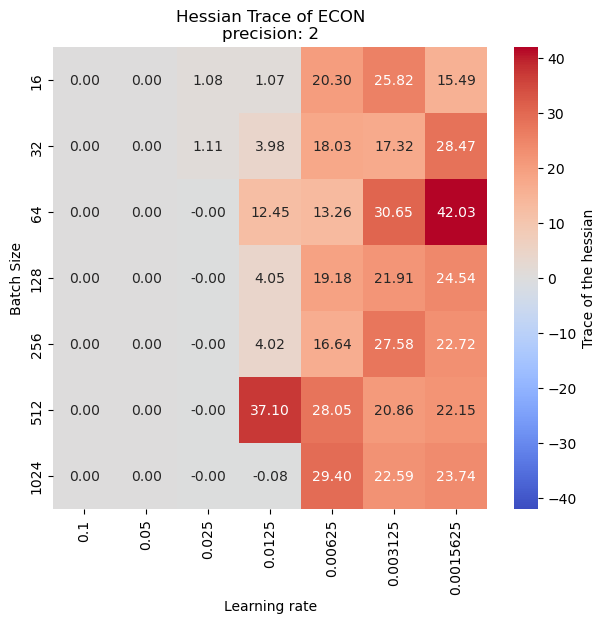

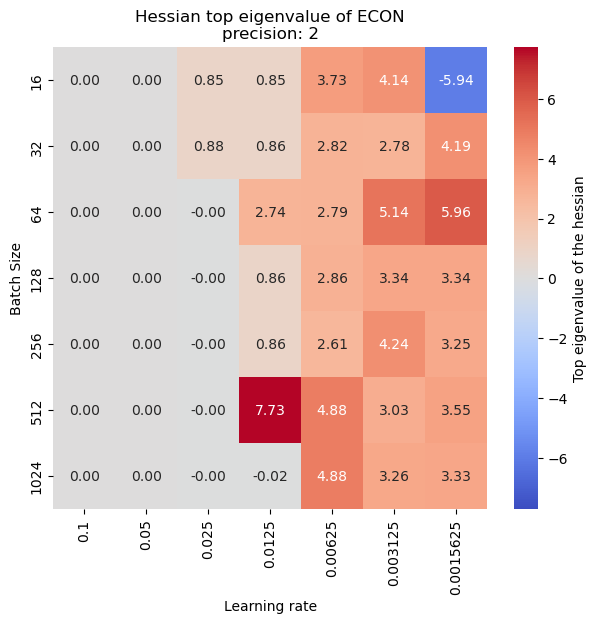

----------------------------------------------------------------------------------------------------


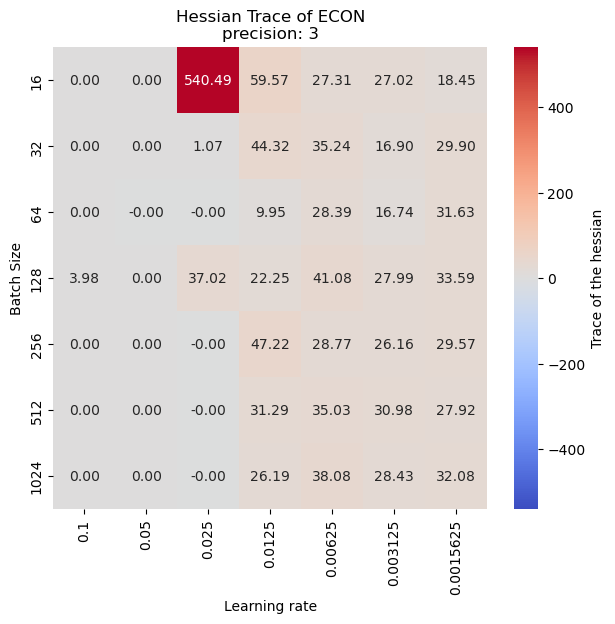

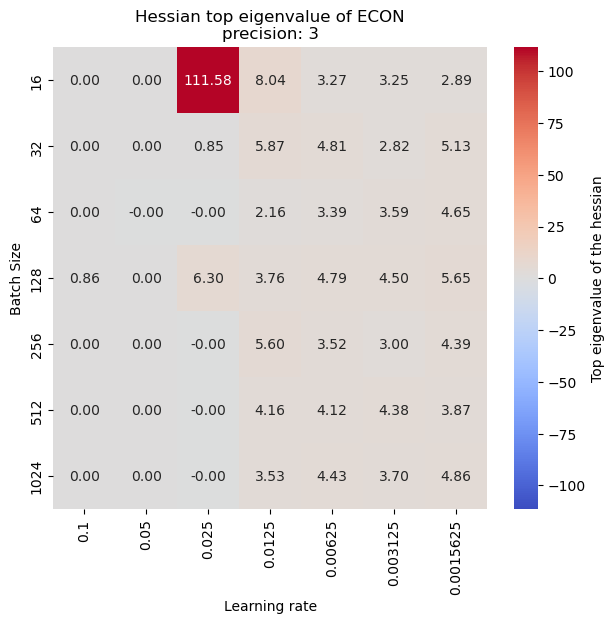

----------------------------------------------------------------------------------------------------


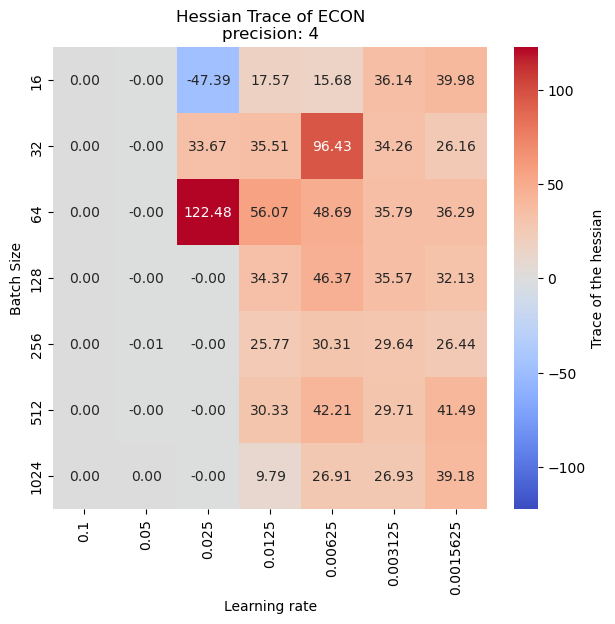

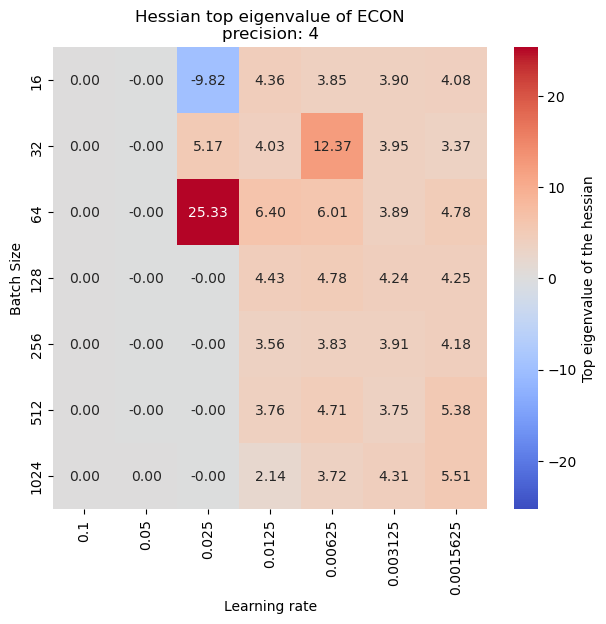

----------------------------------------------------------------------------------------------------


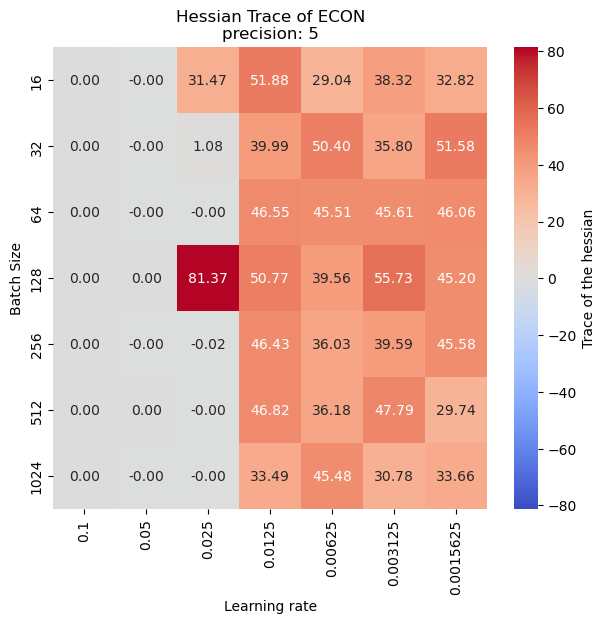

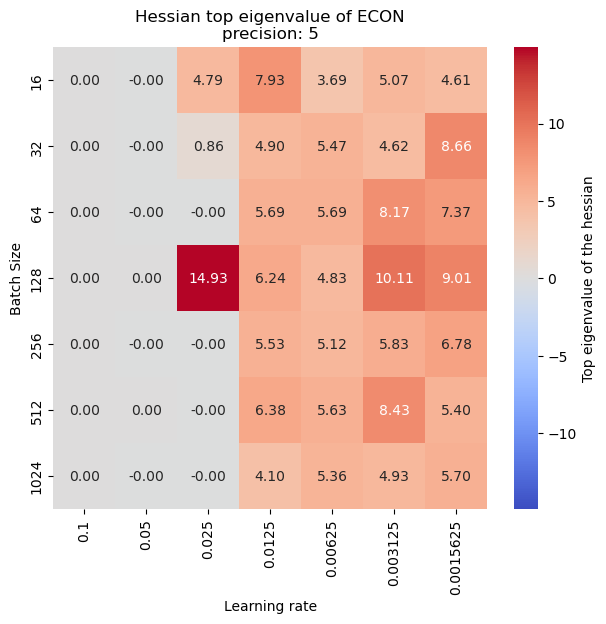

----------------------------------------------------------------------------------------------------


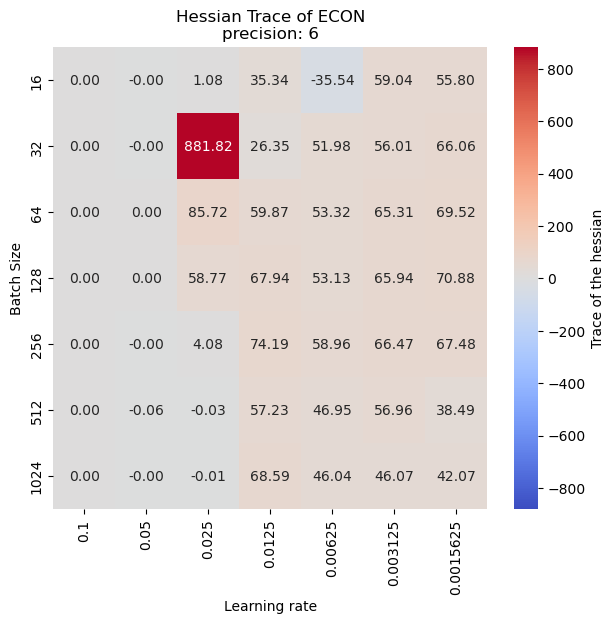

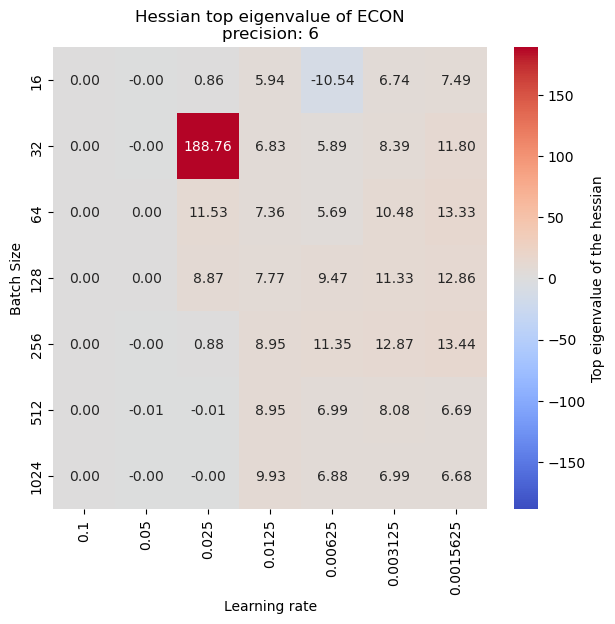

----------------------------------------------------------------------------------------------------


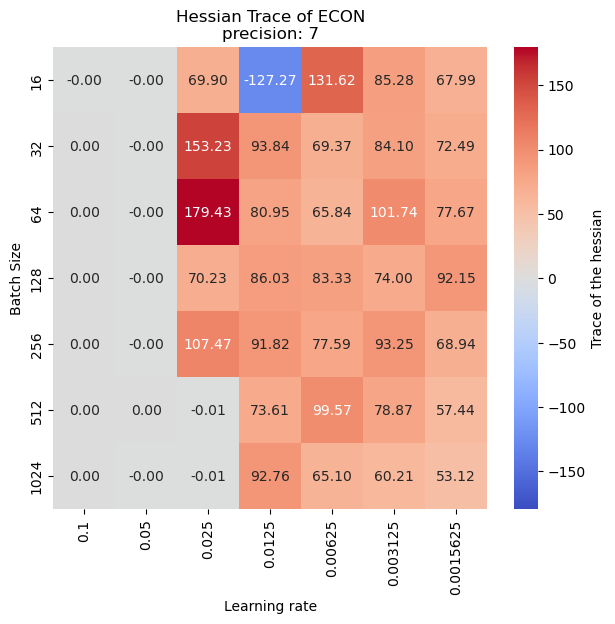

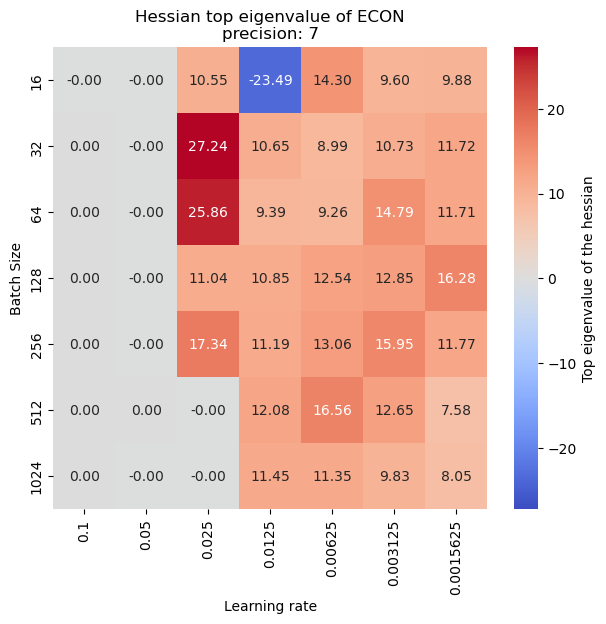

----------------------------------------------------------------------------------------------------


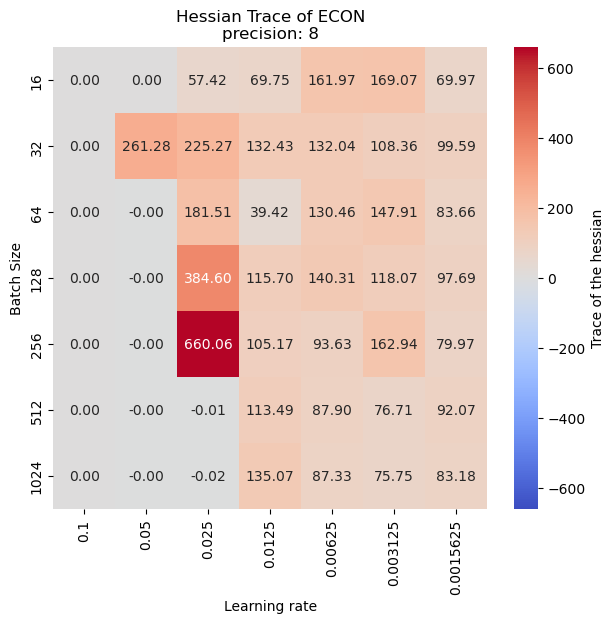

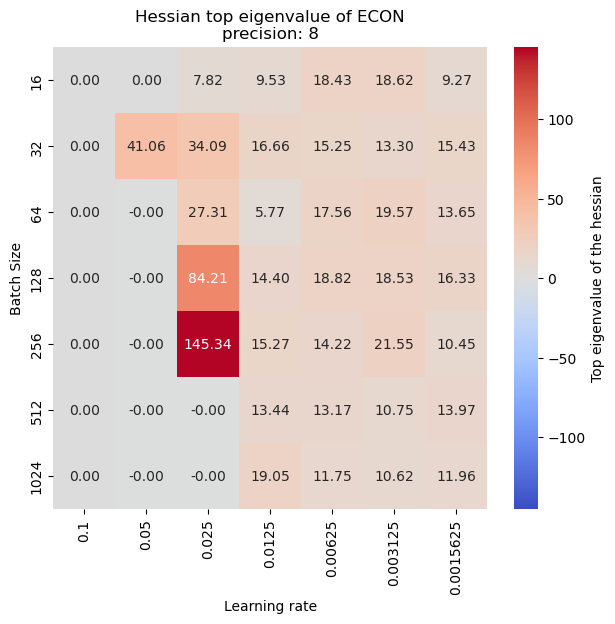

----------------------------------------------------------------------------------------------------


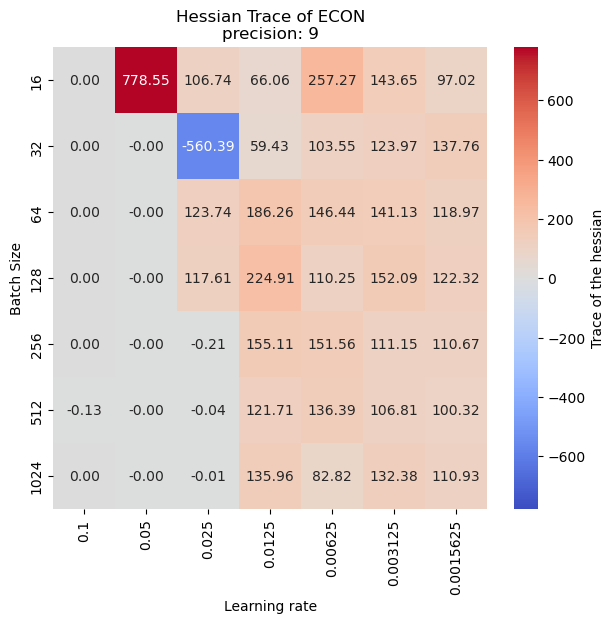

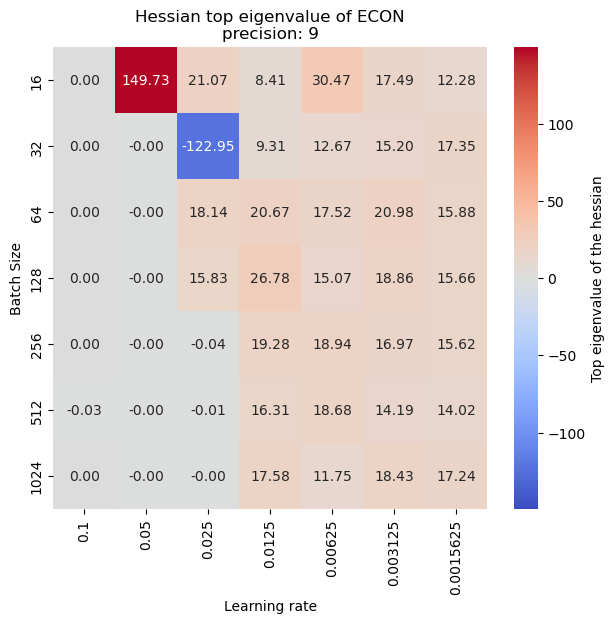

----------------------------------------------------------------------------------------------------


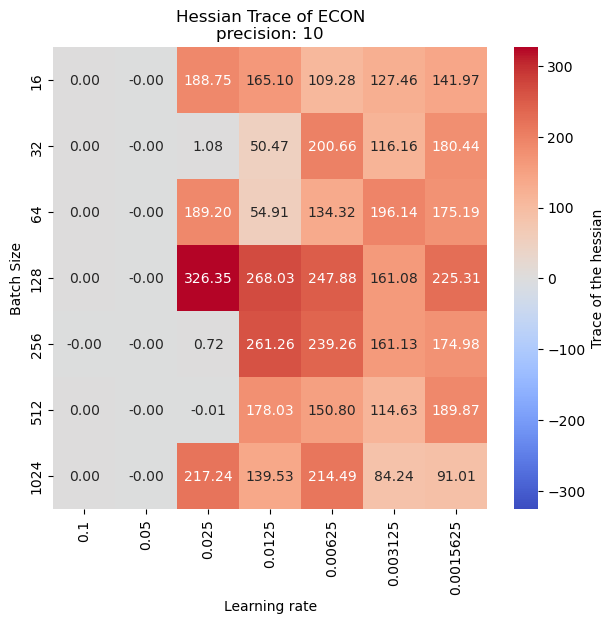

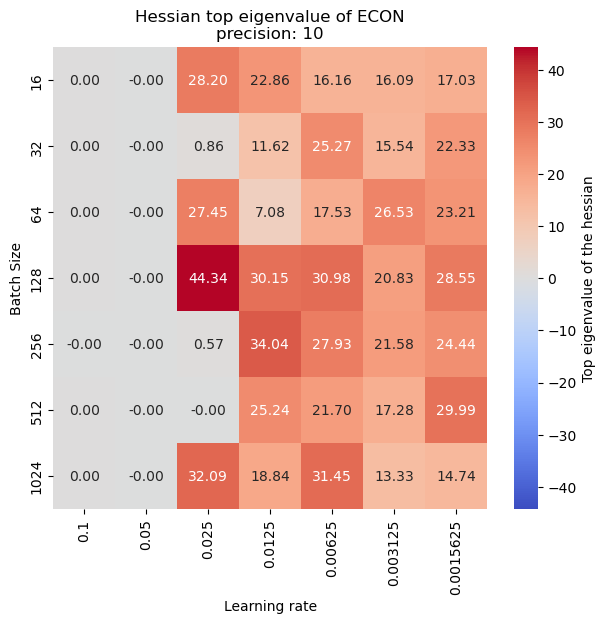

----------------------------------------------------------------------------------------------------


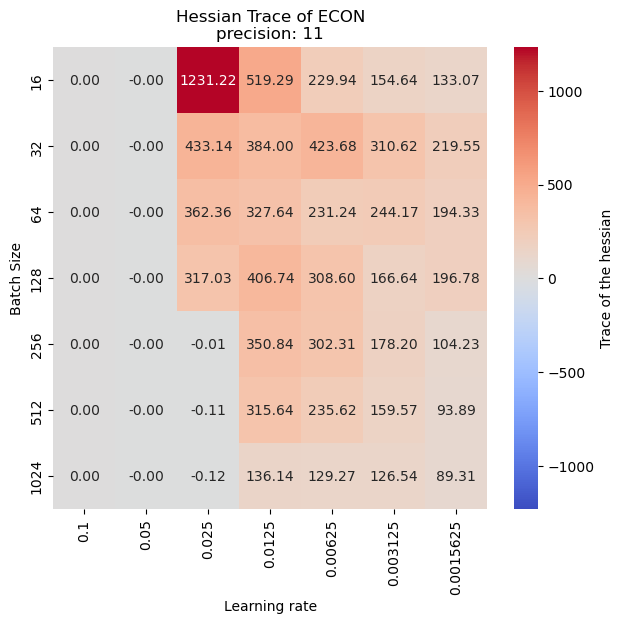

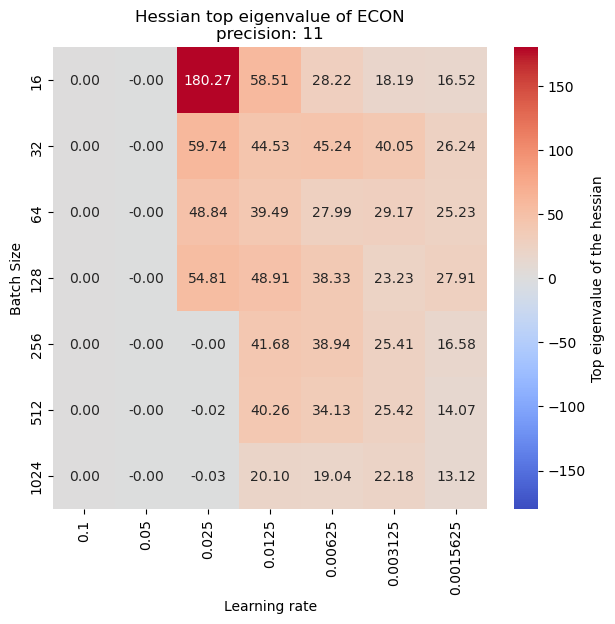

In [6]:
hessian_distribution = []
for p in precisions:
    trace_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    eigen_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            model, emd = econ.load_model(DATA_PATH, bs, lr, p, size)
            path = os.path.join(DATA_PATH, f'bs{bs}_lr{lr}/ECON_{p}b/{size}/')
            hessian = Hessian(model, dataloader)
            
            trace = 0
            eigen_value = 0
            
            for i in range(1, 4):
                hessian.name = f"hessian_{i}"
                trace = []
                eigen_value = []
                if hessian.load_from_file(path):
                    trace.append(sum(hessian.results['trace']))
                    eigen_value.append(hessian.results['eigenvalues'][0])
                    
                
            trace_matrix[x, y] = mean(trace)
            eigen_matrix[x, y] = mean(eigen_value)
            
            hessian_distribution.append({
                'precision': p, 
                'trace': mean(trace),
                'eigenvalue': mean(eigen_value),
                'emd': emd,
                'batch_size': str(bs),
                'learning_rate': str(lr),
            })
            
    trace_matrix = pd.DataFrame(trace_matrix, 
                                index=batch_sizes, 
                                columns=learning_rates)
    eigen_matrix = pd.DataFrame(eigen_matrix, 
                                index=batch_sizes, 
                                columns=learning_rates)
    
    print('-'*100)
    
    plot_2d_heatmap(np.cbrt(trace_matrix), 
                    f'Hessian Trace of ECON\nprecision: {p}', 
                    (-np.cbrt(trace_matrix.max().max()), np.cbrt(trace_matrix.max().max())),
                    'Learning rate',
                    'Batch Size',
                    'Trace of the hessian',
                    cmap='coolwarm')
    
    
    plot_2d_heatmap(np.cbrt(eigen_matrix), 
                    f'Hessian top eigenvalue of ECON\nprecision: {p}', 
                    (-np.cbrt(eigen_matrix.max().max()), np.cbrt(eigen_matrix.max().max())),
                    'Learning rate',
                    'Batch Size',
                    'Top eigenvalue of the hessian',
                    cmap='coolwarm')
            
            

In [7]:
hessian_distribution_df = pd.DataFrame(hessian_distribution)
hessian_distribution_df.to_csv("./results/econ/hessian.csv")

# RN08 (TinyResNet)

In [8]:
DATA_PATH = '/data/tbaldi/work/checkpoint/'
DATASET_DIR = '../../data/RN08'

RN08_layers = [
            'model.conv1', 
            'model.QBlocks.0.conv1', 
            'model.QBlocks.0.conv2', 
            'model.QBlocks.1.conv1', 
            'model.QBlocks.1.conv2',  
            'model.QBlocks.2.conv1', 
            'model.QBlocks.2.conv2',
            'model.QBlocks.2.shortcut',
            'model.QBlocks.3.conv1', 
            'model.QBlocks.3.conv2', 
            'model.QBlocks.4.conv1', 
            'model.QBlocks.4.conv2',
            'model.QBlocks.4.shortcut',
            'model.QBlocks.5.conv1', 
            'model.QBlocks.5.conv2', 
            'model.linear'
        ]

In [9]:
_, _, dataloader = rn08.get_cifar10_loaders(DATASET_DIR, 256)

Files already downloaded and verified


----------------------------------------------------------------------------------------------------


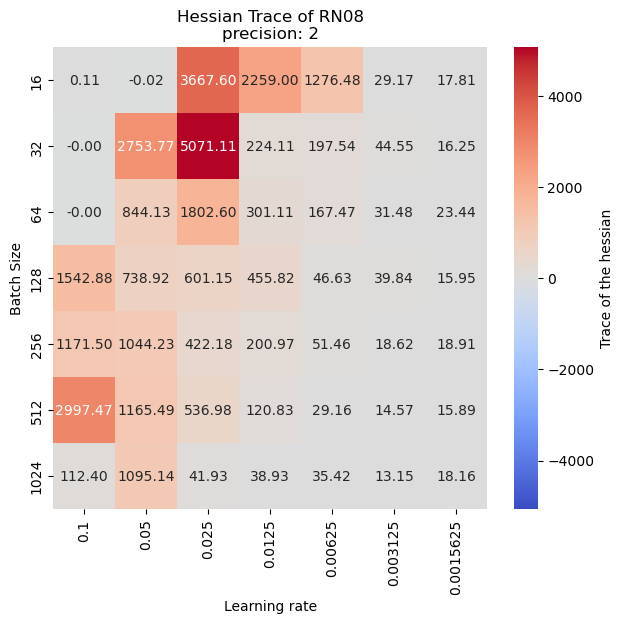

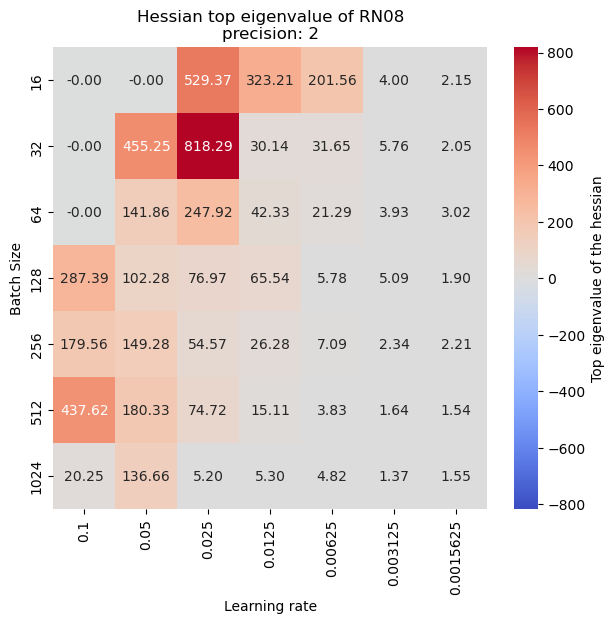

----------------------------------------------------------------------------------------------------


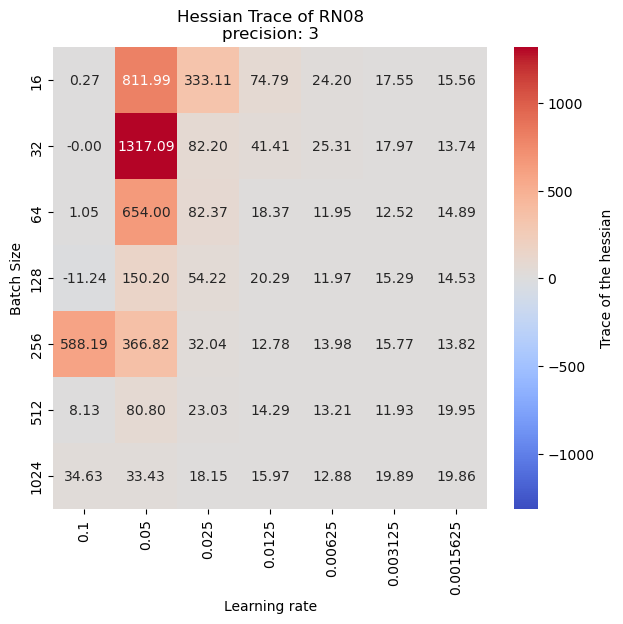

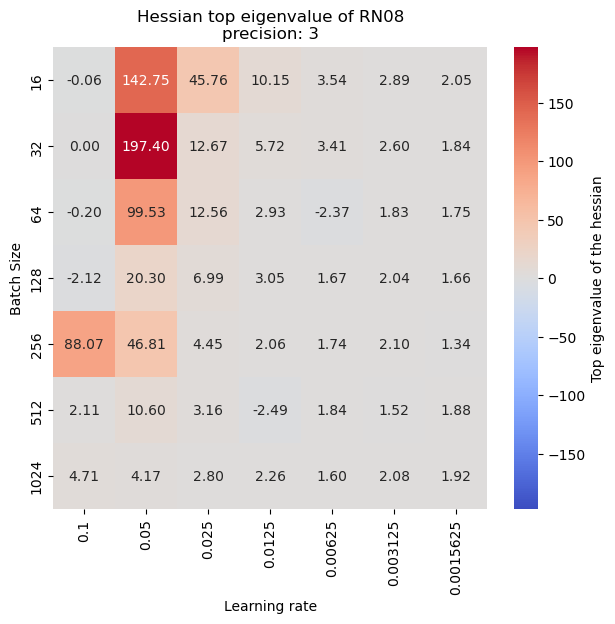

----------------------------------------------------------------------------------------------------


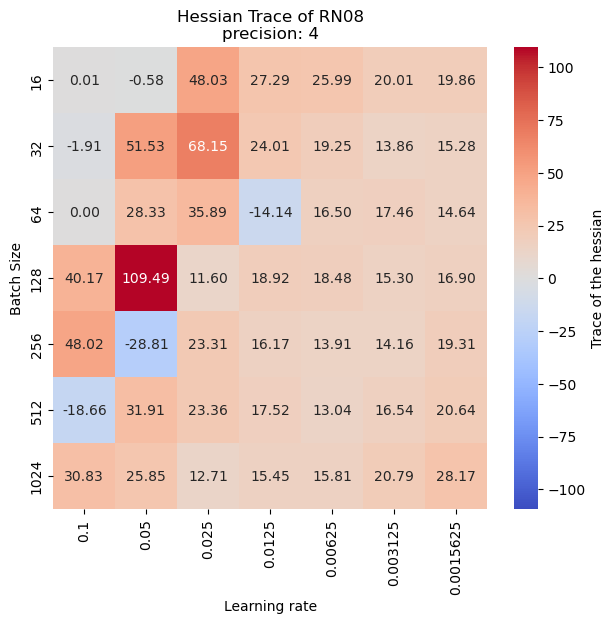

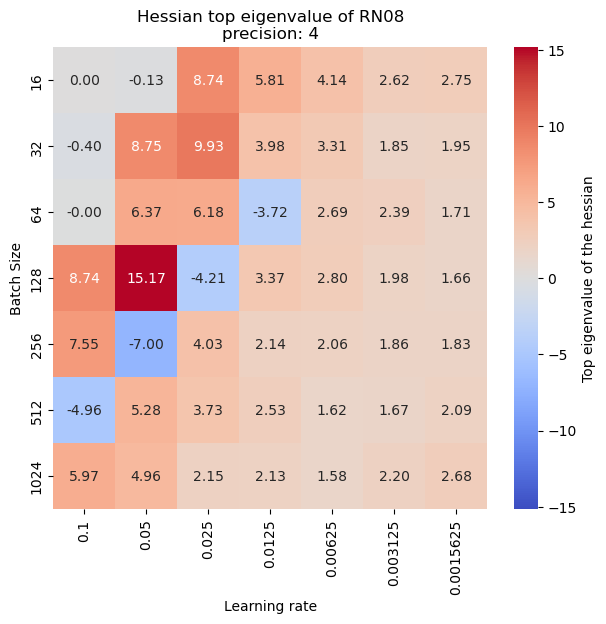

----------------------------------------------------------------------------------------------------


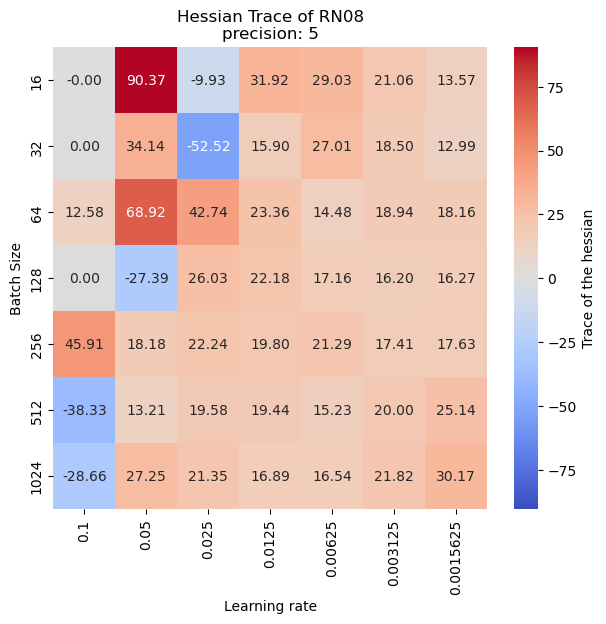

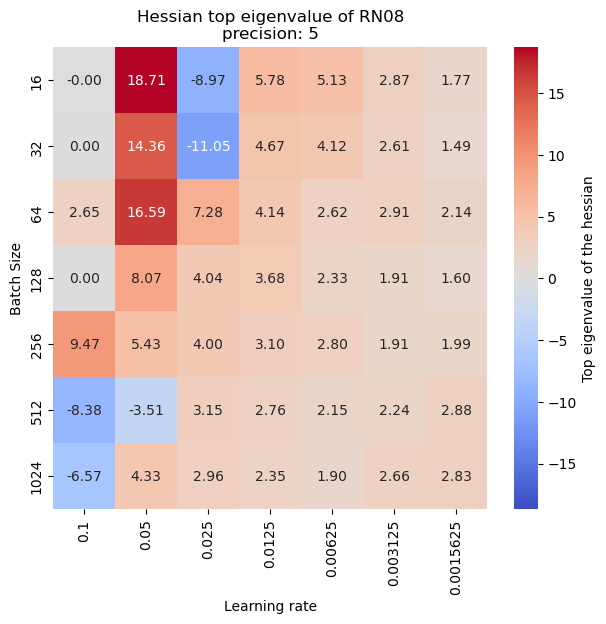

----------------------------------------------------------------------------------------------------


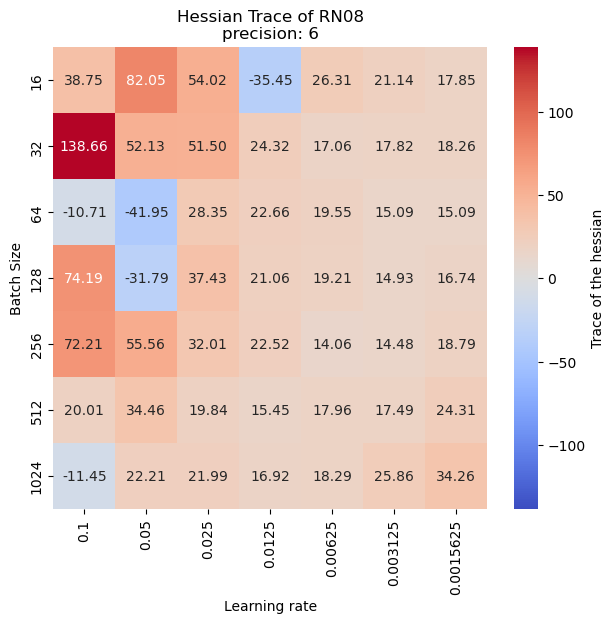

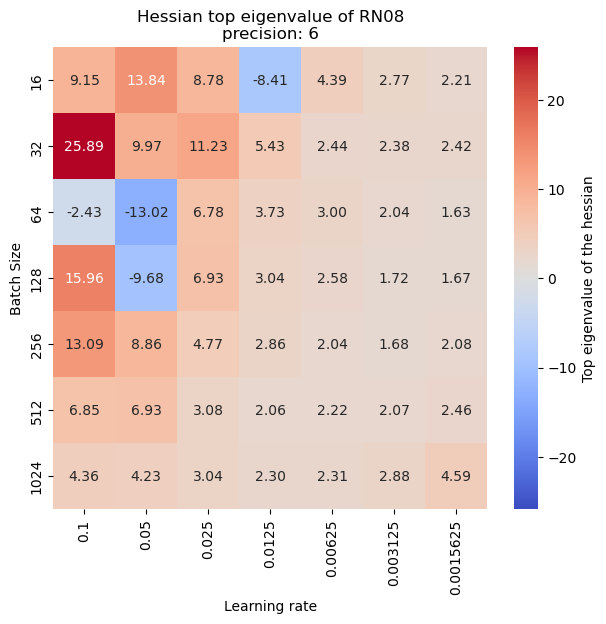

----------------------------------------------------------------------------------------------------


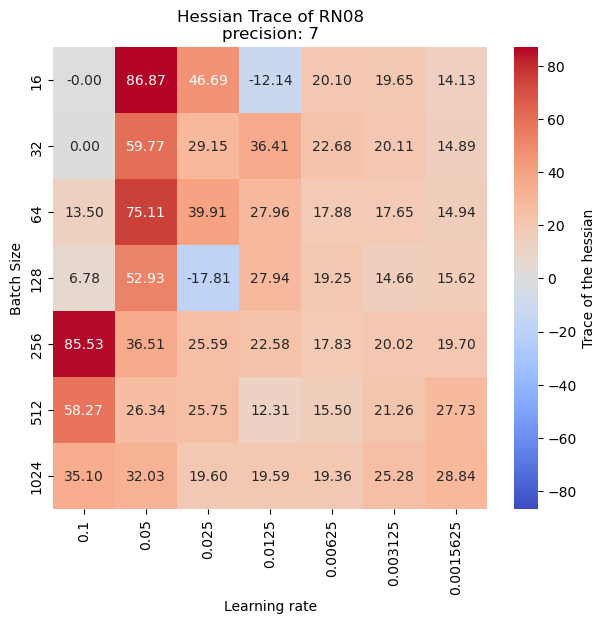

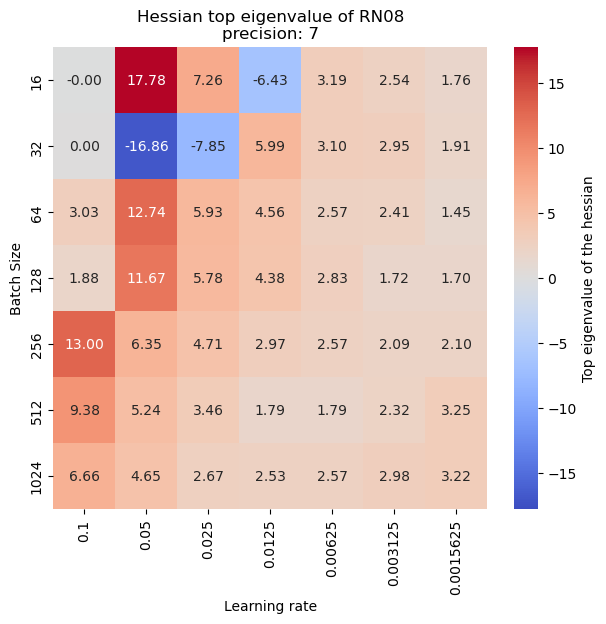

----------------------------------------------------------------------------------------------------


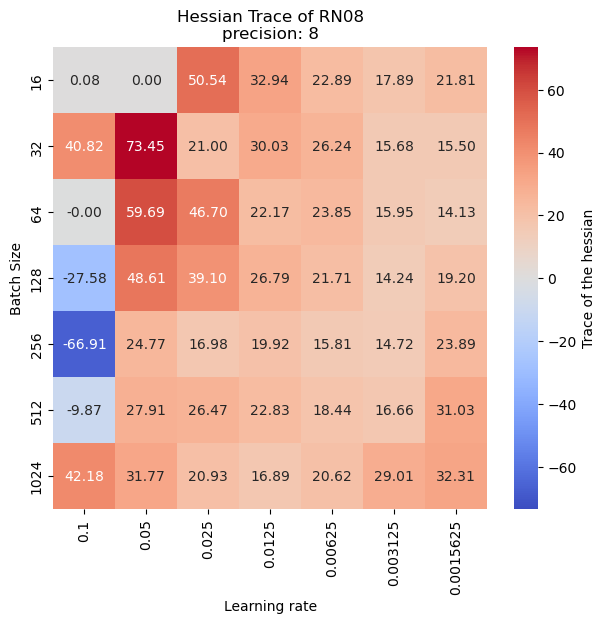

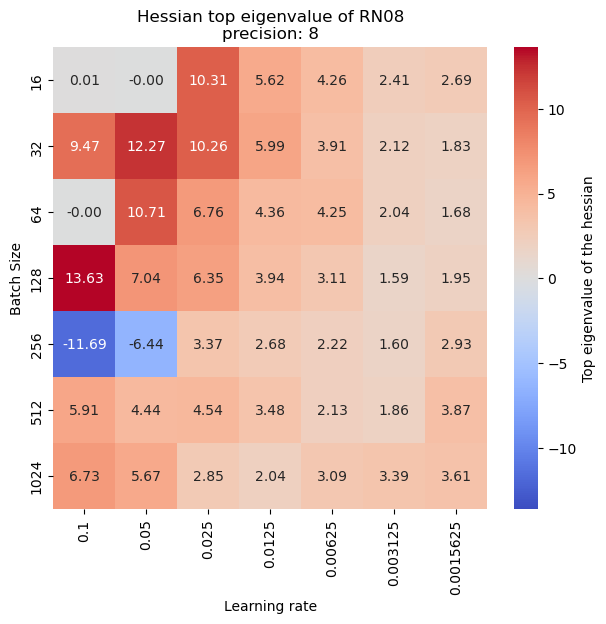

----------------------------------------------------------------------------------------------------


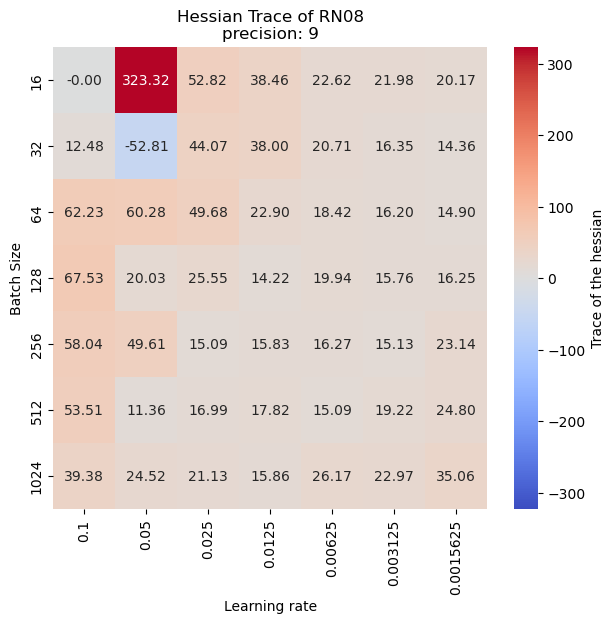

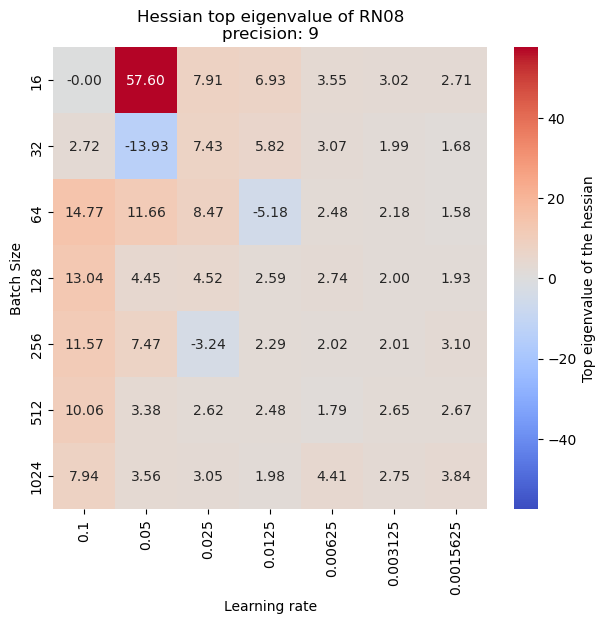

----------------------------------------------------------------------------------------------------


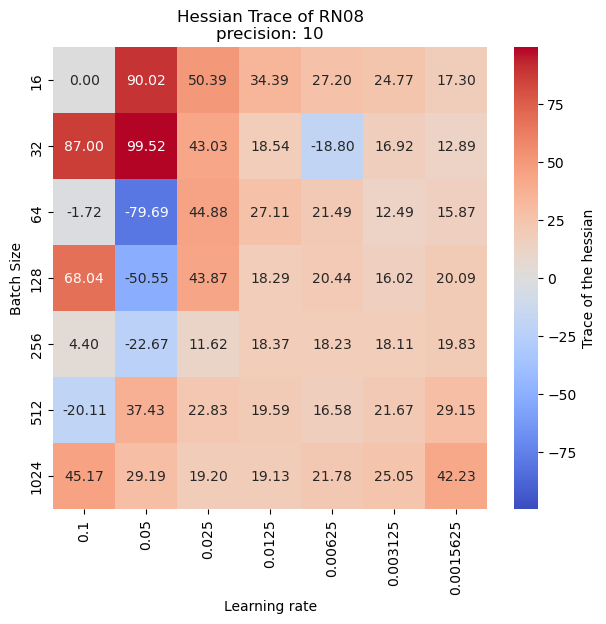

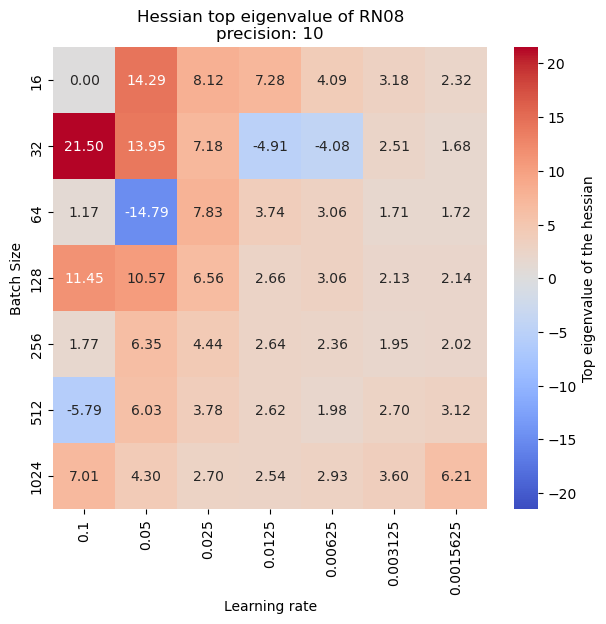

----------------------------------------------------------------------------------------------------


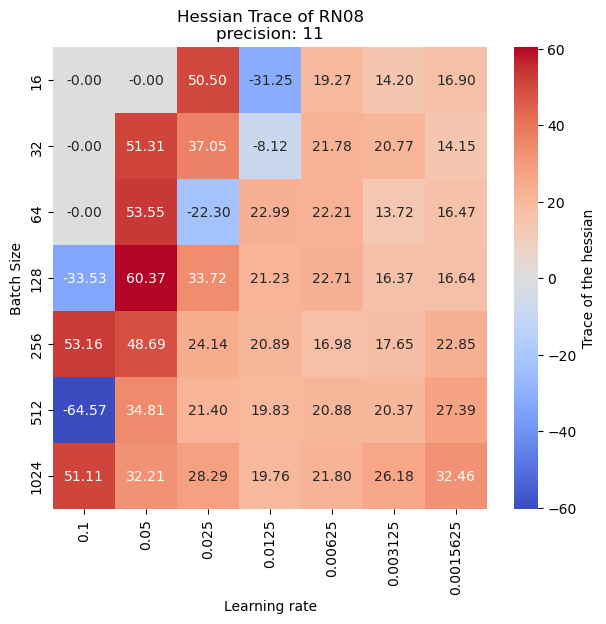

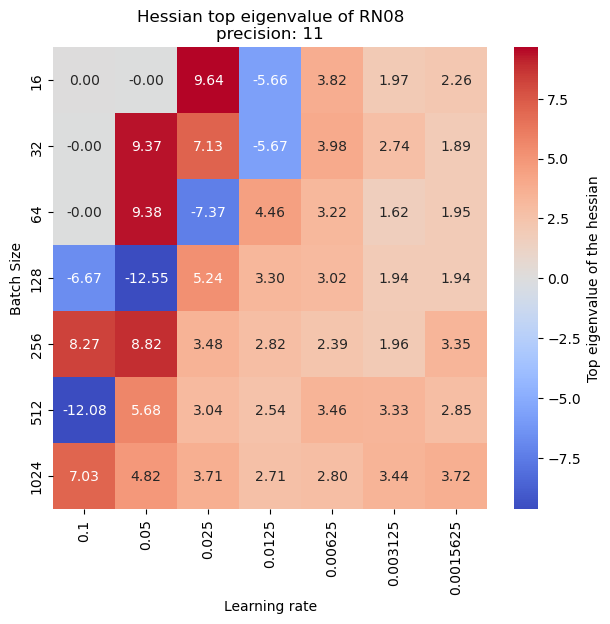

In [10]:
hessian_distribution = []
for p in precisions:
    trace_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    eigen_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            model, acc = rn08.get_model_and_accuracy(DATA_PATH, bs, lr, p)
            path = os.path.join(DATA_PATH, f'bs{bs}_lr{lr}/RN08_{p}b/')
            hessian = Hessian(model, dataloader)
            
            trace = 0
            eigen_value = 0
            
            if hessian.load_from_file(path):
                trace = sum(hessian.results['trace'])
                eigen_value = hessian.results['eigenvalues'][0]
                
            trace_matrix[x, y] = trace
            eigen_matrix[x, y] = eigen_value
            
            hessian_distribution.append({
                'precision': p, 
                'trace': trace,
                'eigenvalue': eigen_value,
                'accuracy': acc,
                'batch_size': str(bs),
                'learning_rate': str(lr),
            })
            
    trace_matrix = pd.DataFrame(trace_matrix, 
                                index=batch_sizes, 
                                columns=learning_rates)
    eigen_matrix = pd.DataFrame(eigen_matrix, 
                                index=batch_sizes, 
                                columns=learning_rates)
    
    print('-'*100)
    
    plot_2d_heatmap(np.cbrt(trace_matrix), 
                    f'Hessian Trace of RN08\nprecision: {p}', 
                    (-np.cbrt(trace_matrix.max().max()), np.cbrt(trace_matrix.max().max())),
                    'Learning rate',
                    'Batch Size',
                    'Trace of the hessian',
                    cmap='coolwarm')
    
    
    plot_2d_heatmap(np.cbrt(eigen_matrix), 
                    f'Hessian top eigenvalue of RN08\nprecision: {p}', 
                    (-np.cbrt(eigen_matrix.max().max()), np.cbrt(eigen_matrix.max().max())),
                    'Learning rate',
                    'Batch Size',
                    'Top eigenvalue of the hessian',
                    cmap='coolwarm')


In [11]:
hessian_distribution_df = pd.DataFrame(hessian_distribution)
hessian_distribution_df.to_csv("./results/rn08/hessian.csv")

In [12]:
for bs in batch_sizes:
    trace_matrix = np.zeros((len(precisions), len(learning_rates)))
    eigen_matrix = np.zeros((len(precisions), len(learning_rates)))
    for y, lr in enumerate(learning_rates):
        for x, p in enumerate(precisions):

            model, acc = rn08.get_model_and_accuracy(DATA_PATH, bs, lr, p)
            path = os.path.join(DATA_PATH, f'bs{bs}_lr{lr}/RN08_{p}b/')
            hessian = Hessian(model, dataloader)
        
            trace = 0
            eigen_value = 0
            
            if hessian.load_from_file(path):
                trace = sum(hessian.results['trace'])
                eigen_value = hessian.results['eigenvalues'][0]
                
            trace_matrix[x, y] = trace
            eigen_matrix[x, y] = eigen_value
                
            
    # plot the heatmaps per precision
    trace_matrix = pd.DataFrame(trace_matrix, 
                                index=precisions, 
                                columns=learning_rates)
    
    eigen_matrix = pd.DataFrame(eigen_matrix, 
                                index=precisions, 
                                columns=learning_rates)
    print('-'*100)
    
    plot_2d_heatmap(np.cbrt(trace_matrix), 
                    f'Hessian Trace of RN08\n batch size: {bs}', 
                    (0, 100),
                    'Learning rate',
                    'Precision',
                    'Hessian Trace',
                    cmap='viridis_r')
    plot_2d_heatmap(np.cbrt(eigen_matrix), 
                    f'Hessian Trace of RN08\n batch size: {bs}', 
                    (0, 100),
                    'Learning rate',
                    'Precision',
                    'Hessian Top eigenvalue',
                    cmap='viridis_r')